In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from scipy.optimize import minimize

import astropy.units as u

import pandas as pd
import exoplanet as xo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare, id_segments, EasyE
from flarePipeline import vetFlare

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [31]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1/'

# Flux jump
f1 = 'tess2018206045859-s0001-0000000025200252-0120-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

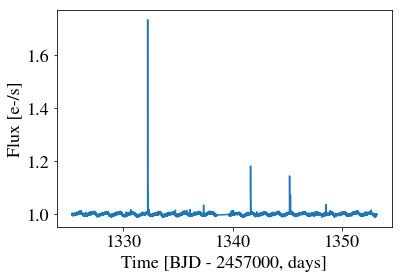

In [32]:
with fits.open(path+f1, mode='readonly') as hdulist:
    #print(hdulist[1].header)
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
mask = (tess_quality == 0) & (~np.isnan(tess_bjds))

time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.nanmedian(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')
#plt.xlim(1624.8,1628)

In [33]:
dt_limit = 12/24 # 12 hours
trim = 4/24 # 4 hours
istart, istop = id_segments(time, dt_limit, dt_trim=trim)

time_trim = np.array([])
flux_trim = np.array([])
error_trim = np.array([])

for seg_idx in range(len(istart)):
    print(time[istart[seg_idx]], time[istop[seg_idx]])
    time_seg = time[istart[seg_idx]:istop[seg_idx]]
    flux_seg = flux[istart[seg_idx]:istop[seg_idx]]
    error_seg = error[istart[seg_idx]:istop[seg_idx]]

    time_trim = np.concatenate((time_trim, time_seg), axis=0)
    flux_trim = np.concatenate((flux_trim, flux_seg), axis=0)
    error_trim = np.concatenate((error_trim, error_seg), axis=0)
    
time = time_trim
flux = flux_trim
error = error_trim
    
median = np.nanmedian(flux)

1325.4678844746538 1338.359812254791
1339.8334400586955 1353.0000616905552


Text(0, 0.5, 'Flux [e-/s]')

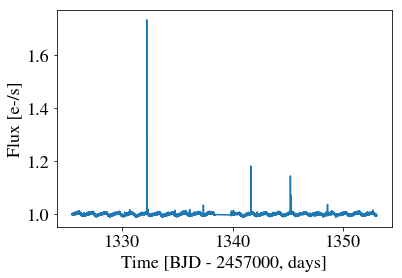

In [34]:
plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

In [35]:
acf = xo.autocorr_estimator(time, flux/median,
                        yerr=error/median,
                        min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    acf_1dt = (time[-1] - time[0])/2
    s_window = 128
acf_1dt

1.2173495341614853

/astro/users/scw7/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


17597 17583
17583 17582
17582 17575
17575 17569
17569 17562
17562 17556
17556 17548
17548 17543
17543 17539
17539 17535
17535 17534
17534 17534


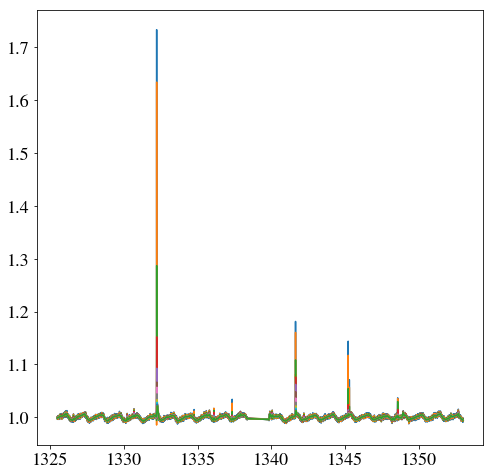

In [36]:
num_iter = 20

x = time
y = flux/median
yerr = error/median

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-20, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter('log_Q')

# A periodic component
Q = 1.0
w0 = 2*np.pi/acf_1dt
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# Now calculate the covariance matrix using the initial
# kernel parameters
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)

def neg_log_like(params, y, gp, m):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y[m])

def grad_neg_log_like(params, y, gp,m ):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y[m])[1]

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()

fig, axes = plt.subplots(figsize=(8,8))
axes.plot(x, y)

# Find the best fit kernel parameters. We want to try to ignore the flares
# when we do the fit. To do this, we will repeatedly find the best fit
# solution to the kernel model, calculate the covariance matrix, predict
# the flux and then mask out points based on how far they deviate from
# the model. After a few passes, this should cause the model to fit mostly
# to periodic features.
m = np.ones(len(x), dtype=bool)
for i in range(num_iter):
    gp.compute(x[m], yerr[m])
    soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method='L-BFGS-B', bounds=bounds, args=(y, gp, m))
    gp.set_parameter_vector(soln.x)
    initial_params = soln.x
    smo = gp.predict(y[m], x, return_cov=False, return_var=False)
    axes.plot(x, smo)
    #axes.set_xlim(1427,1428)
    var = np.nanvar(y - smo)
    sig = np.sqrt(var + yerr**2)

    m0 = y - smo < 1.3 * sig
    n_pts_prev = np.sum(m)
    n_pts = np.sum(m0)
    print(n_pts_prev, n_pts)
    if n_pts == 0:
        print('Warning: all points thrown out (noisy LC?)')
        break
    m = m0
    if (n_pts == n_pts_prev): #or np.fabs(n_pts - n_pts_prev) < 3:
        break

gp.compute(x[m], yerr[m])
smo = gp.predict(y[m], time, return_cov=False, return_var=False)

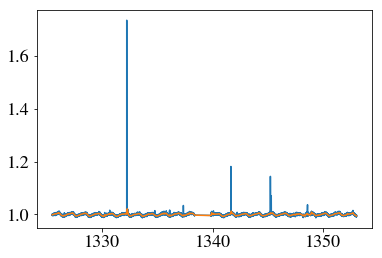

In [37]:
plt.plot(time, flux/median)
plt.plot(time, smo)

In [38]:
roll = pd.DataFrame(smo).rolling(s_window, center=True).std().values
roll = roll.reshape(1, -1)[0]
mask = np.isfinite(roll)

(0.001240903036559487, 0.000988376126488035)

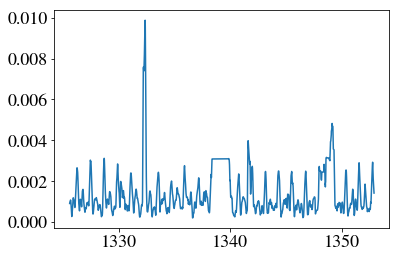

In [39]:
plt.plot(time[mask], roll[mask])
np.mean(roll[mask]), np.std(roll[mask])

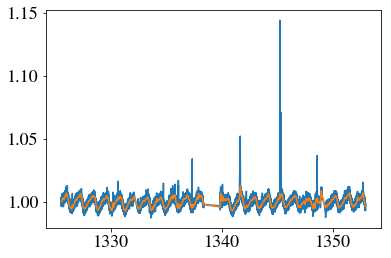

In [40]:
time_cut = time[mask]
flux_cut = flux[mask]
error_cut = error[mask]
smo_cut = smo[mask]
mask1 = roll[mask] < np.std(smo)
time = time_cut[mask1]
flux = flux_cut[mask1]
smo = smo_cut[mask1]
error = error_cut[mask1]
plt.plot(time, flux/median)
plt.plot(time, smo)

In [41]:
# Search for flares in the smoothed light curve using change point analysis
FL = FINDflare(flux/median - smo, error/median,
               avg_std=True, std_window=s_window, N1=3, N2=1, N3=3)

1330.6749584304298 1330.6791251925295 2.1550516837210614 1.0188559528743542
1330.674163438661 0.0034474555066793975
[5.52273064 5.12302503] s
1334.7528146137504 1334.7569813413481 1.3335675495491646 3.3960515766773045
1334.7530516340205 0.000556169919680312
[2.78412655 0.4597548 ] s
1336.0931111517657 1336.0972778747077 3.2583534764280557 9.200086353368372
1336.0937189023452 0.0025174680188244183
[8.01155667 3.6572673 ] s
1337.334796578786 1337.3417411309404 2.5775311399161476 7.409175929571853
1337.3349799089274 0.0014578840726638073
[9.0006979  2.06035966] s
1341.6473349976973 1341.6626127998784 4.464785885014751 0.7850808317638962
1341.647894478955 0.005989717371239222
[25.97712592  4.50678436] s
1345.207055447616 1345.2153887597215 1.2898760720175928 36.48833219145819
1345.2072809402093 0.0008297276409733079
[31.56338616  0.94828775] s
1345.2848330244667 1345.2903885658698 14.752030048448622 8.428838624959857
1345.2848370611473 0.0027777001225942404
[14.67305689  4.19144081] s
1348

(1341.5, 1341.8)

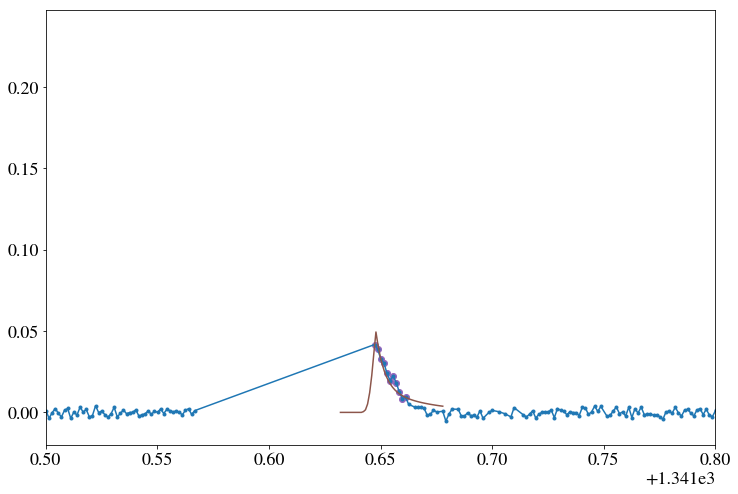

In [43]:
from flareTools import aflare1
from flarePipeline import measure_ED
fig, axes = plt.subplots(figsize=(12,8))
axes.plot(time, flux/median-smo, marker='o', markersize=3)
for j in range(len(FL[0])):
    s1, s2 = FL[0][j], FL[1][j]+1
    axes.scatter(time[s1:s2], flux[s1:s2]/median-smo[s1:s2])#, color='r')
    
    tstart, tstop = time[s1], time[s2]
    dx_fac = 2
    popt1, pstd1, g_chisq, popt2, pstd2, f_chisq = vetFlare(time, flux/median-smo,\
                                                            error/median, tstart, tstop, \
                                                            dx_fac=dx_fac)
    
    dx = tstop - tstart
    x1 = tstart - dx*dx_fac/2
    x2 = tstop + dx*dx_fac/2
    
    xmodel = np.linspace(x1, x2)
    ymodel = aflare1(xmodel, popt2[0], popt2[1], popt2[2])
    plt.plot(xmodel, ymodel)
    print(tstart, tstop, f_chisq, g_chisq)
    
    ed = measure_ED(time, flux/median-smo, error/median, popt2[0], popt2[1])
    print(popt2[0], popt2[1])
    print((ed*u.d).to(u.s))
    
plt.xlim(1341.5,1341.8)